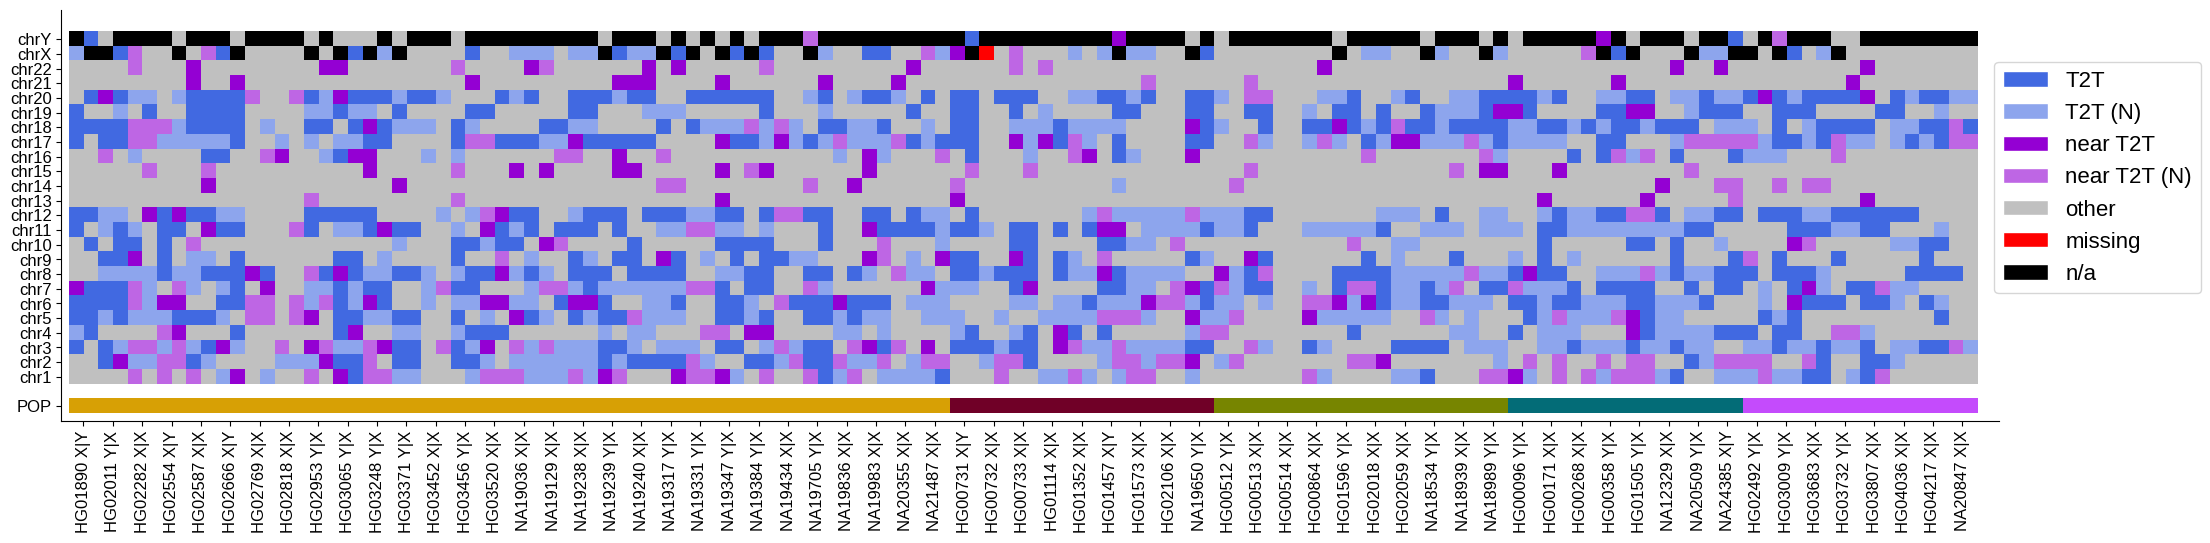

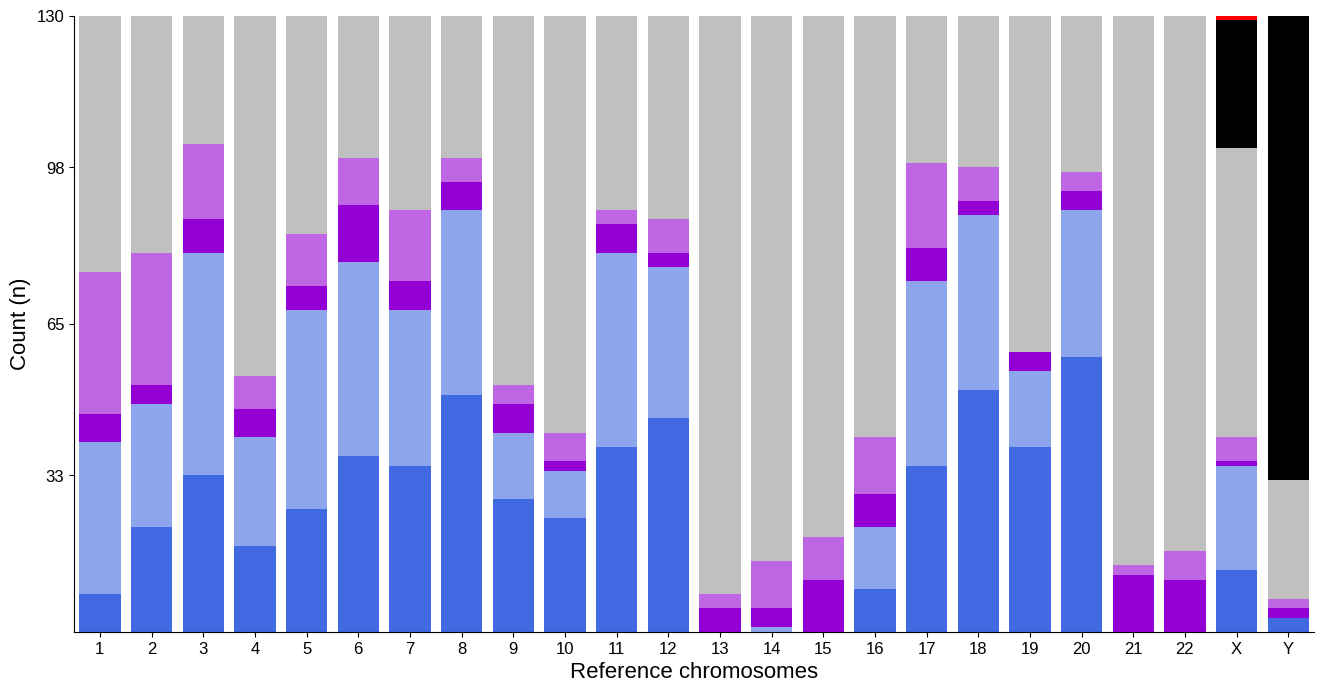

In [92]:
%run -n "../../00_project_config.ipynb"
%run -n "../../05_plot_config.ipynb"
%run -n "../../10_assm_stats.ipynb"

import collections as collect
import statistics as stat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb as name_to_rgb

t2t_criteria = "strict"

# see NB:
# notebooks/assembly_stats/correctness/plot-qv-estimates.ipynb
cache_qv_table = PROJECT_BASE.joinpath(
    "notebooks", ".cache", "qv_est_merged.tsv.gz"
)

# see NB:
# notebooks/assembly_stats/correctness/plot-qv-estimates.ipynb
cache_ngap_table = PROJECT_BASE.joinpath(
    "notebooks", ".cache", "contigs_with_ngap.tsv.gz"
)

karyo_est = PROJECT_DATA_ROOT.joinpath(
    "2023_karyo_est", "karyo-est.hgsvc3.tsv"
)

annotation_source = PROJECT_DATA_ROOT.joinpath(
    "2024_ref_span", "hgsvc3"
)

def read_karyotype_table(file_path):
    
    df = pd.read_csv(file_path, sep="\t", header=0, comment="#")
    lut = dict(
        ((row.sample.split(".")[0], row.asm_unit.split("-")[-1]), row.karyotype)
        for row in df.itertuples()
    )
    return lut


def read_cached_qv_est(file_path):
    
    file_path.resolve(strict=True)
    df = pd.read_csv(file_path, sep="\t", header=0)
    lut = dict(
        ((row.sample, row.seq_name), row.qv) for row
        in df.itertuples()
    )
    return lut

def read_cached_ngap_summary(file_path):
    
    file_path.resolve(strict=True)
    df = pd.read_csv(file_path, sep="\t", header=0)
    lut = dict(
        (sample, set(contigs)) for sample, contigs
        in df.groupby("sample")["contig"]
    )
    return lut


def read_all_ref_span_tables(qv_est, ngaps, karyo):
    
    merged = []
    for table in annotation_source.glob("*.tsv"):
        df = read_ref_span_table(table, qv_est, ngaps, karyo)
        merged.append(df)
        
    merged = pd.concat(merged, axis=0, ignore_index=False)
    return merged


def read_ref_span_table(file_path, qv_est, ngaps, karyo):
    
    sample = file_path.name.split(".")[0]
    asm_unit = file_path.name.split(".")[2].split("-")[-1]
    df = pd.read_csv(file_path, sep="\t", header=0, comment="#")
    df["sample"] = sample
    df["asm_unit"] = asm_unit
    df["qv"] = [qv_est[(row.sample, row.contig)] for row in df.itertuples()]
    df["ngaps"] = df["contig"].apply(lambda c: 1 if c in ngaps[sample] else 0)
    df["sex"] = [karyo.get((row.sample, row.asm_unit), "any") for row in df.itertuples()]
    
    return df

qv = read_cached_qv_est(cache_qv_table)
ngaps = read_cached_ngap_summary(cache_ngap_table)
karyo = read_karyotype_table(karyo_est)

ref_spans = read_all_ref_span_tables(qv, ngaps, karyo)


def labelize(criteria, single_contig, telo_p, telo_q, is_spanning, high_qual, no_gaps):
    
    assert criteria in ["strict", "lenient"]
    
    if criteria == "strict":
        has_telo = telo_p and telo_q
    else:
        has_telo = telo_p or telo_q
    
    check = [single_contig, has_telo, is_spanning, high_qual, no_gaps]
    if all(check):
        return "t2t"
    check = [single_contig, has_telo, is_spanning, high_qual]
    if all(check):
        return "t2t_ngap"
    
    check = [has_telo, is_spanning, high_qual, no_gaps]
    if all(check):
        return "near_t2t"
    check = [has_telo, is_spanning, high_qual]
    if all(check):
        return "near_t2t_ngap"
    
    return "other"


def summarize_chromosome_status(ref_spans, criteria):
    
    assert criteria in ["strict", "lenient"]
    
    summary = dict()
    
    for (sample, hap, chrom), infos in ref_spans.groupby(["sample", "asm_unit", "chrom"]):
        
        is_single_contig = infos.shape[0] == 1
        has_p_telomere = (infos["telo_p"] > 0).any()
        has_q_telomere = (infos["telo_q"] > 0).any()
        is_spanning = infos["length_ratio"].sum() > 0.95
        if chrom == "chrY":
            is_spanning = infos["length_ratio"].sum() > 0.6
        if chrom == "chr9":
            is_spanning = infos["length_ratio"].sum() > 0.9
        high_quality = (infos["qv"] > 50).all()
        no_ngaps = (infos["ngaps"] < 1).all()
       
        label = labelize(
            criteria,
            is_single_contig, has_p_telomere, has_q_telomere,
            is_spanning, high_quality, no_ngaps
        )
        summary[(sample, hap, chrom)] = (
            infos["sex"].iloc[0], label,
            is_single_contig, has_p_telomere, has_q_telomere,
            is_spanning, high_quality, no_ngaps
        )
        
    return summary


assm_summary = summarize_chromosome_status(ref_spans, t2t_criteria)
    
label_color_map = collect.OrderedDict({
    "t2t": (*name_to_rgb("royalblue"), 1),
    "t2t_ngap": (*name_to_rgb("royalblue"), 0.6),
    "near_t2t": (*name_to_rgb("darkviolet"), 1),
    "near_t2t_ngap": (*name_to_rgb("darkviolet"), 0.6),
    "other": (*name_to_rgb("silver"), 1),
    "na": (0,0,0,1),
    "missing": (*name_to_rgb("red"), 1),
})


def plot_assembly_summary(assm_summary, label_color_map):
    
    
    ref_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    hap_order = ["hap1", "hap2"]
    
    row_nums = HGSVC_TOTAL * len(hap_order)
    col_nums = len(ref_chroms) + 2
    
    row_label_pos = []
    row_labels = []
    
    im_matrix = np.ones(
        (row_nums, col_nums, 4)
    )
    red, green, blue, alpha = 0, 1, 2, 3
    
    chrom_summary = collect.defaultdict(collect.Counter)
    
    row = 0
    for pop, sample in get_samples_ordered_by_pop():
        pop_color = (*get_pop_color(sample), 1)
        row_label = sample
        
        current_sex = None
        for hap in hap_order:
            
            col = 2
            for chrom in ref_chroms:
                try:
                    assm_spec = assm_summary[(sample, hap, chrom)]
                    current_sex = assm_spec[0]
                    label = assm_spec[1]
                    assert label in label_color_map
                    r,g,b,a = label_color_map[label]
                except KeyError:
                    label = "missing"
                    r,g,b,a = label_color_map[label]
                    if current_sex is not None:
                        if current_sex == "female" and chrom == "chrY":
                            r,g,b,a = label_color_map["na"]
                            label = "na"
                        if current_sex == "male" and chrom == "chrX":
                            r,g,b,a = label_color_map["na"]
                            label = "na"
                            
                    # logic fix for HG00732
                    if (sample == "HG00732" and 
                        current_sex == "any" and 
                        chrom == "chrY" and 
                        label == "missing"):
                        r,g,b,a = label_color_map["na"]
                        label = "na"
                        
                chrom_summary[chrom][label] += 1
                            
                im_matrix[row, col, red] = r
                im_matrix[row, col, green] = g
                im_matrix[row, col, blue] = b
                im_matrix[row, col, alpha] = a
                
                im_matrix[row, 0, :] = pop_color
                
                col += 1
            if hap == "hap2":
                if current_sex == "male":
                    row_label += "|Y"
                else:
                    row_label += "|X"
                row_label_pos.append(row - 0.5 )
                row_labels.append(row_label)
            if hap == "hap1":
                if current_sex == "male":
                    row_label += " Y"
                else:
                    row_label += " X"
            row += 1

    im_matrix = np.swapaxes(im_matrix, 0, 1)        
    
    fig, ax = plt.subplots(figsize=(25, 15))
    
    ax.imshow(
        im_matrix,
        aspect="equal"
    )
    
    ax.set_ylim(-1,col_nums+1)
    ax.set_xlim(-1,row_nums+1)

    y_ticks = [0] + list(range(2, 26))
    y_ticklabels = ["POP"] + ref_chroms
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticklabels)
    
    ax.set_xticks(row_label_pos)
    ax.set_xticklabels(row_labels, rotation=90)
    
    # realize via color map directly
    legend = build_patch_legend(
        [
            ("T2T", label_color_map["t2t"]),
            ("T2T (N)", label_color_map["t2t_ngap"]),
            ("near T2T", label_color_map["near_t2t"]),
            ("near T2T (N)", label_color_map["near_t2t_ngap"]),
            ("other", label_color_map["other"]),
            ("missing", label_color_map["missing"]),
            ("n/a", label_color_map["na"])
        ]
    )
    
    ax.legend(handles=legend, bbox_to_anchor=(1.11, 0.9))
    
    return chrom_summary


def summarize_labels_by_chromosome(chrom_summary, label_color_map):
            
    ref_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    bar_pos = list(range(1, 25))
    
    fig, ax = plt.subplots(figsize=(16,8))
    
    bottom = np.zeros(len(ref_chroms), dtype=float)    
    for label in label_color_map.keys():
        
        row_heights = np.array(
            [chrom_summary[c][label] for c in ref_chroms],
            dtype=float
        )
        label_color = label_color_map[label]
        ax.bar(
            bar_pos,
            row_heights,
            bottom=bottom,
            color=label_color
        )
        bottom += row_heights
        
    ax.set_xticks(bar_pos)
    ax.set_xticklabels([c.strip("chr") for c in ref_chroms])
    
    yticks = [33, 65, 98, 130]
    ax.set_yticks(yticks)
    ax.set_yticklabels(list(map(str, yticks)))
    
    ax.set_xlabel("Reference chromosomes")
    ax.set_ylabel("Count (n)")
    
    ax.set_xlim(0.5, 24.5)
        
    return
        

chrom_summary = plot_assembly_summary(assm_summary, label_color_map)

summarize_labels_by_chromosome(chrom_summary, label_color_map)
                    
        
        
    
